In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import os
import requests
import io
import PIL
import PIL.Image
import math
import pathlib
import numpy as np

In [2]:
batch_size = 8 # 每⼀批所处理的图⽚数量
img_height = 256 # 图⽚⾼度，单位为像素
img_width = 256 # 图⽚宽度，单位为像素

TF_SERVING_BASE_URL = 'http://localhost:8501/'
image_dir = './datasets/flower_photos'

task_id = '350002'
task_dir = os.path.join('./datasets/', task_id)
train_dir = os.path.join(task_dir, 'train')
test_dir = os.path.join(task_dir, 'test')

In [3]:
import shutil

id_code_mapping = { # 根据web界⾯显示情况设定
'daisy' : '0',
'dandelion' : '1', 
'roses' : '2', 
'sunflowers' : '3', 
'tulips' : '4', 
}
total_image_count = len(list(pathlib.Path(image_dir).glob('*/*.jpg')))
print(total_image_count)
print(train_dir)

for img in pathlib.Path(image_dir).glob('*/*.jpg'): 
    if np.random.ranf() < 0.8: # 需要通过修改数值来控制测试集的⽐例
      dst_dir = os.path.join(train_dir, os.path.basename(os.path.dirname(img)))
    else:
      dst_dir = os.path.join(test_dir, os.path.basename(os.path.dirname(img)))
    if not os.path.exists(dst_dir):
      os.makedirs(dst_dir)
    #print(os.path.dirname(img))
    dst = os.path.join(dst_dir, img.name)
    #print(dst)
    #dst = os.path.join(dst_dir, record['id']+'.png')
    #img.save(dst)
    shutil.copy(img, dst)

3670
./datasets/350002/train


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
validation_split=0.2, # 设定验证集⽐例
subset="training",
seed=123,
#image_size=(img_height, img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
validation_split=0.2, # 设定验证集⽐例
subset="validation",
seed=123,
#image_size=(img_height, img_width),
batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [6]:
print(train_ds.class_names)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
(8, 256, 256, 3)
(8,)


In [7]:
augmentation_dict = {
    'RandomFlip': tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    'RandomRotation': tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    'RandomContrast': tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
    'RandomZoom': tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1),
    'RandomTranslation': tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    'RandomCrop': tf.keras.layers.experimental.preprocessing.RandomCrop(img_height, img_width),

}

In [8]:
num_classes = 5

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

from keras.models import Model
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from keras.layers import Activation, BatchNormalization, Add, Reshape, DepthwiseConv2D
from keras.utils.vis_utils import plot_model
 
from keras import backend as K

def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v
 
 
def relu6(x):
    """Relu 6
    """
    return K.relu(x, max_value=6.0)
 
 
def _conv_block(inputs, filters, kernel, strides):
    """Convolution Block
    This function defines a 2D convolution operation with BN and relu6.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution along the width and height.
            Can be a single integer to specify the same value for
            all spatial dimensions.
    # Returns
        Output tensor.
    """
 
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
 
    x = Conv2D(filters, kernel, padding='same', strides=strides)(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)
 
 
def _bottleneck(inputs, filters, kernel, t, alpha, s, r=False):
    """Bottleneck
    This function defines a basic bottleneck structure.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        alpha: Integer, width multiplier.
        r: Boolean, Whether to use the residuals.
    # Returns
        Output tensor.
    """
 
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    # Depth
    tchannel = K.int_shape(inputs)[channel_axis] * t
    # Width
    cchannel = int(filters * alpha)
 
    x = _conv_block(inputs, tchannel, (1, 1), (1, 1))
 
    x = DepthwiseConv2D(kernel, strides=(s, s), depth_multiplier=1, padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)
 
    x = Conv2D(cchannel, (1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization(axis=channel_axis)(x)
 
    if r:
        x = Add()([x, inputs])
 
    return x
 
 
def _inverted_residual_block(inputs, filters, kernel, t, alpha, strides, n):
    """Inverted Residual Block
    This function defines a sequence of 1 or more identical layers.
    # Arguments
        inputs: Tensor, input tensor of conv layer.
        filters: Integer, the dimensionality of the output space.
        kernel: An integer or tuple/list of 2 integers, specifying the
            width and height of the 2D convolution window.
        t: Integer, expansion factor.
            t is always applied to the input size.
        alpha: Integer, width multiplier.
        s: An integer or tuple/list of 2 integers,specifying the strides
            of the convolution along the width and height.Can be a single
            integer to specify the same value for all spatial dimensions.
        n: Integer, layer repeat times.
    # Returns
        Output tensor.
    """
 
    x = _bottleneck(inputs, filters, kernel, t, alpha, strides)
 
    for i in range(1, n):
        x = _bottleneck(x, filters, kernel, t, alpha, 1, True)
 
    return x
 
 
def MobileNetv2(input_shape, k, alpha=1.0):
    """MobileNetv2
    This function defines a MobileNetv2 architectures.
    # Arguments
        input_shape: An integer or tuple/list of 3 integers, shape
            of input tensor.
        k: Integer, number of classes.
        alpha: Integer, width multiplier, better in [0.35, 0.50, 0.75, 1.0, 1.3, 1.4].
    # Returns
        MobileNetv2 model.
    """
    inputs = Input(shape=input_shape)
 
    first_filters = _make_divisible(32 * alpha, 8)
    x = _conv_block(inputs, first_filters, (3, 3), strides=(2, 2))
 
    x = _inverted_residual_block(x, 16, (3, 3), t=1, alpha=alpha, strides=1, n=1)
    x = _inverted_residual_block(x, 24, (3, 3), t=6, alpha=alpha, strides=2, n=2)
    x = _inverted_residual_block(x, 32, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 64, (3, 3), t=6, alpha=alpha, strides=2, n=4)
    x = _inverted_residual_block(x, 96, (3, 3), t=6, alpha=alpha, strides=1, n=3)
    x = _inverted_residual_block(x, 160, (3, 3), t=6, alpha=alpha, strides=2, n=3)
    x = _inverted_residual_block(x, 320, (3, 3), t=6, alpha=alpha, strides=1, n=1)
 
    if alpha > 1.0:
        last_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_filters = 1280
 
    x = _conv_block(x, last_filters, (1, 1), strides=(1, 1))
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1, 1, last_filters))(x)
    x = Dropout(0.3, name='Dropout')(x)
    x = Conv2D(k, (1, 1), padding='same')(x)
 
    x = Activation('softmax', name='softmax')(x)
    output = Reshape((k,))(x)
 
    model = Model(inputs, output)
    # plot_model(model, to_file='images/MobileNetv2.png', show_shapes=True)
 
    return model


model = MobileNetv2((256, 256, 3), 100, 1.0)

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
model.compile(
optimizer='adam',
loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
metrics=['accuracy'])

In [10]:
model.fit(
train_ds,
validation_data=val_ds,
epochs=3
)

Epoch 1/3
367/367 [==============================] - 343s 919ms/step - loss: 4.2951 - accuracy: 0.3290 - val_loss: 4.3824 - val_accuracy: 0.2398
Epoch 2/3
367/367 [==============================] - 354s 963ms/step - loss: 4.2548 - accuracy: 0.3678 - val_loss: 4.2612 - val_accuracy: 0.3583
Epoch 3/3
367/367 [==============================] - 363s 990ms/step - loss: 4.2556 - accuracy: 0.3661 - val_loss: 4.2324 - val_accuracy: 0.3883


In [11]:
tf.keras.models.save_model(
model,
'./models/image/1/', # ./models为tensorflow-serving的模型根⽬录
overwrite=True,
include_optimizer=True,
save_format=None,
signatures=None,
options=None
)

INFO:tensorflow:Assets written to: ./models/image/1/assets


/Users/sunxiaohua/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [12]:
import numpy as np
import json
import matplotlib.pyplot as plt
def test_image_model(test_dir,  code, batch_size=10): 
  imgs = []
  codes = []
  imgdir = os.path.join(test_dir, val_ds.class_names[code]) 
  print(imgdir)
  right = 0
  wrong = 0
  for i in pathlib.Path(imgdir).glob('./*.jpg'): 
    #print(i.name)
    imgs = []
    img = PIL.Image.open(i)
    pixels = np.array(img)
    plt.imshow(pixels)
    imgs.append(pixels.tolist()) 
    img.close()
    for j in range(int(math.ceil(len(imgs)/batch_size))):
      req_data = json.dumps({
        'inputs': imgs[j*batch_size:(j+1)*batch_size],
      })
    
    #data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
    #http://localhost:8501/v1/models/fashion_mnist:predict
    #print(TF_SERVING_BASE_URL+'v1/models/image/versions/1:predict')
    #response = requests.post(TF_SERVING_BASE_URL+'v1/models/image/versions/1:predict', # 根据部署地址填写
    #json_response = requests.post('http://localhost:8501/v1/models/fashion_mnist:predict', data=data, headers=headers)
    response = requests.post(TF_SERVING_BASE_URL+'v1/models/image:predict', # 根据部署地址填写
    data=req_data,
    headers={"content-type": "application/json"})
    #print(response.status_code)
    if response.status_code != 200:
      raise RuntimeError('Request tf-serving failed: ' + response.text)
    resp_data = json.loads(response.text) 
    if 'outputs' not in resp_data \
         or type(resp_data['outputs']) is not list:
      raise ValueError('Malformed tf-serving response')
    #print(np.argmax(resp_data['outputs']))
    if( int(np.argmax(resp_data['outputs']) == int(code) )):
       right = right + 1
    else:
       wrong = wrong + 1
    #codes.extend(np.argmax(resp_data['outputs'], axis=1).tolist())
    #print("class:"+ str(np.argmax(resp_data['outputs'])))
  return right/(right+wrong)

./datasets/350002/test/daisy


RuntimeError: Request tf-serving failed: {
    "error": "Servable not found for request: Latest(image)"
}

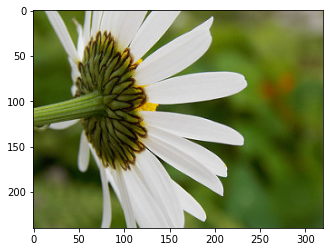

In [13]:
codes = test_image_model(test_dir,  0)
print('类别0的准确率', codes)
codes = test_image_model(test_dir, 1)
print('类别1的准确率', codes)